In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold

## 1. Loading the dataset

In [2]:
train_df = pd.read_csv("./playground-series-s3e22/train.csv")
test_df = pd.read_csv("./playground-series-s3e22/test.csv")

train_df.shape, test_df.shape

((1235, 29), (824, 28))

## 2. EDA

In [3]:
train_df.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [4]:
train_df['peristalsis'].loc[train_df['peristalsis'] == 'distend_small']

676    distend_small
Name: peristalsis, dtype: object

In [5]:
train_df.outcome.unique()

array(['died', 'euthanized', 'lived'], dtype=object)

There are 3 possible outcomes of each horse treatment

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1235 non-null   object 
 8   peripheral_pulse       1235 non-null   object 
 9   mucous_membrane        1235 non-null   object 
 10  capillary_refill_time  1235 non-null   object 
 11  pain                   1235 non-null   object 
 12  peristalsis            1235 non-null   object 
 13  abdominal_distention   1235 non-null   object 
 14  nasogastric_tube       1235 non-null   object 
 15  naso

## 2.1 Dataset distribution by outcomes

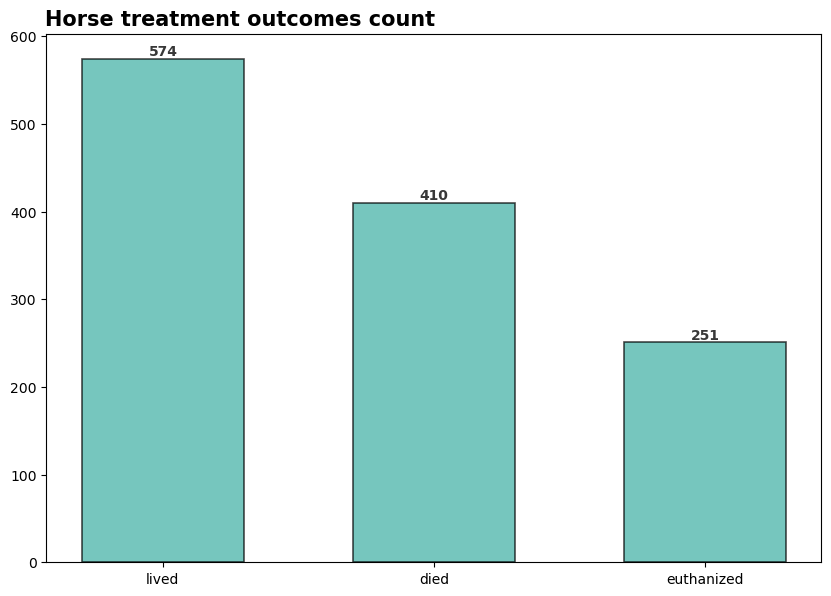

In [7]:


plt.figure(figsize=(10, 7), dpi=100)
plt.bar(train_df['outcome'].value_counts().keys(), train_df["outcome"].value_counts(), color='#3caea3',
        alpha=0.7, width=0.6, edgecolor='black', linewidth=1.2)
plt.title("Horse treatment outcomes count", fontsize=15, fontweight='bold', position=(0.25, 1.0+0.05))
for i in train_df["outcome"].unique():
    plt.annotate(f"{train_df['outcome'].value_counts()[i]}", 
                   xy=(i, train_df['outcome'].value_counts()[i] + 8),
                   va = 'center', ha='center',fontweight='bold', color='#383838'
                   )

Patients who lived make up almost 50% of the dataset

## 2.2 Correlation matrix

<ipython-input-8-1a1de0dc90ea>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df[list(train_df.columns)].corr()


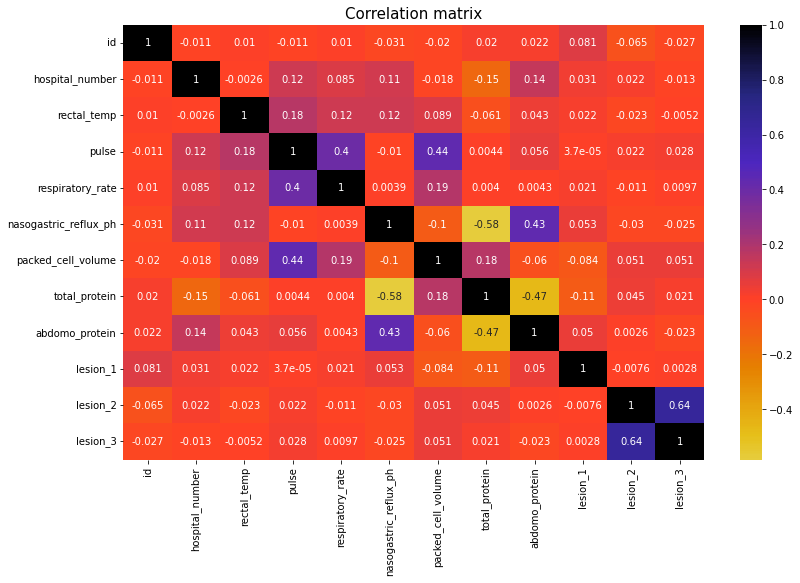

In [8]:
corr = train_df[list(train_df.columns)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap=plt.cm.CMRmap_r , annot = True, center = 0)
plt.title('Correlation matrix', fontsize = 15)
plt.show()


lesion_3 is highly correlated with lesion_2

In [9]:
# Columns to encode with 2 unique values
train_df[[col for col in train_df.columns if len(train_df[col].unique()) == 2]].columns

Index(['surgery', 'age', 'surgical_lesion', 'lesion_3', 'cp_data'], dtype='object')

In [10]:
# Columns to encode with one_hot_encoding with more than 2 unique options
cols_with_more_than_3_values = train_df[[col for col in train_df.columns if (len(train_df[col].unique()) > 2 and
                                     col != "outcome" and
                                     train_df[col].dtype == 'O')]].columns
cols_with_more_than_3_values

Index(['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
       'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention',
       'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces',
       'abdomen', 'abdomo_appearance'],
      dtype='object')

In [11]:
# Finding columns with singlar unique value
for col in cols_with_more_than_3_values:
    potential_value = train_df[col].value_counts().loc[train_df[col].value_counts() == 1]
    if len(potential_value) > 0:
        print(potential_value)
    

slight    1
Name: pain, dtype: int64
distend_small    1
Name: peristalsis, dtype: int64
slight    1
Name: nasogastric_reflux, dtype: int64
serosanguious    1
Name: rectal_exam_feces, dtype: int64


## 3. General data preprocessing

In [12]:

def preprocess_df(df: pd.DataFrame, test_set: bool):
    df.copy()
    # 1. Binary encoding
    columns_to_binary_encode_yesno = ["surgery", "surgical_lesion", "cp_data"]
    for col in columns_to_binary_encode_yesno: 
        df[col] = df[col].eq("yes").mul(1)
    
    df["age"] = df["age"].eq("adult").mul(1)
    
    # 2. Remapping outcomes
    outcomes = {'lived': 0,
                'died': 1, 
                'euthanized': 2}

    if not test_set:
        df['outcome'] = df['outcome'].map(outcomes) 
        
    # 4. Encoding categorical features
    
    # Replacing rows with values appearing only once in the dataframe
    df["pain"] = df["pain"].replace("slight", "moderate")
    df["peristalsis"] = df["peristalsis"].replace('distend_small', 'normal')
    df["rectal_exam_feces"] = df["rectal_exam_feces"].replace('serosanguious', 'absent')
    df["nasogastric_reflux"] = df["nasogastric_reflux"].replace('slight', 'none')
    
    df["temp_of_extremities"] = df["temp_of_extremities"].map({'cold': 0, 'cool': 1, 'normal': 2, 'warm': 3, 'None': 2})
    df["peripheral_pulse"] = df["peripheral_pulse"].map({'absent': 0, 'reduced': 1, 'normal': 2, 'increased': 3, 'None': 2})
    df["capillary_refill_time"] = df["capillary_refill_time"].map({'less_3_sec': 0, '3': 1, 'more_3_sec': 2, 'None': 3})
    df["pain"] = df["pain"].map({'alert': 0, 'depressed': 1, 'moderate': 2, 'mild_pain': 3, 'severe_pain': 4, 'extreme_pain': 5, 'None': 1})
    df["peristalsis"] = df["peristalsis"].map({'hypermotile': 0, 'normal': 1, 'hypomotile': 2, 'absent': 3, 'None': 1})
    df["abdominal_distention"] = df["abdominal_distention"].map({'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3, 'None': 0})
    df["nasogastric_tube"] = df["nasogastric_tube"].map({'none': 0, 'slight': 1, 'significant': 2, 'None': 0})
    df["nasogastric_reflux"] = df["nasogastric_reflux"].map({'less_1_liter': 0, 'none': 1, 'more_1_liter': 2, 'None': 1})
    df["rectal_exam_feces"] = df["rectal_exam_feces"].map({'absent': 0, 'decreased': 1, 'normal': 2, 'increased': 3, 'None': 0})
    df["abdomen"] = df["abdomen"].map({'normal': 0, 'other': 1, 'firm': 2,'distend_small': 3, 'distend_large': 4, 'None': 3})
    df["abdomo_appearance"] = df["abdomo_appearance"].map({'clear': 0, 'cloudy': 1, 'serosanguious': 2, 'None': 2})
    
    # 5. One hot encoding additional column
    df= pd.get_dummies(df, columns=["mucous_membrane"])
    
    # 6. Dropping correlated dependent feature
    df.drop('lesion_3',axis=1,inplace=True)
        
    return df
    

In [13]:
preprocessed_df = preprocess_df(train_df, False)


In [14]:
preprocessed_df.isnull().any().any()

False

In [15]:
preprocessed_df.head(10)


,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,capillary_refill_time,...,lesion_2,cp_data,outcome,mucous_membrane_None,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink
0,0,1,1,530001,38.1,132.0,24.0,1,1,2,...,0,0,1,0,0,0,1,0,0,0
1,1,1,1,533836,37.5,88.0,12.0,1,2,2,...,0,0,2,0,0,0,0,0,1,0
2,2,1,1,529812,38.3,120.0,28.0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,3,1,1,5262541,37.1,72.0,30.0,0,1,2,...,0,1,0,0,0,0,0,0,0,1
4,4,0,1,5299629,38.0,52.0,48.0,2,2,0,...,0,1,0,0,0,0,0,1,0,0
5,5,0,1,529642,38.1,56.0,32.0,2,2,0,...,0,1,0,0,1,0,0,0,0,0
6,6,1,1,534787,38.3,36.0,16.0,1,1,0,...,0,1,2,0,0,0,0,1,0,0
7,7,0,1,529461,39.2,114.0,24.0,1,1,2,...,0,1,1,0,0,0,0,0,1,0
8,8,0,1,528742,37.4,48.0,12.0,1,1,0,...,0,1,0,0,0,0,0,1,0,0
9,9,1,1,529640,38.3,129.0,48.0,1,1,0,...,0,1,1,0,0,0,0,0,0,1


In [16]:
preprcessed_test_df = preprocess_df(test_df, True)

## 4. Modelling 1.0

In [17]:
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold


In [18]:
X = preprocessed_df.drop(["outcome", "id"], axis=1)
y = preprocessed_df["outcome"]

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42) 
kf = KFold(n_splits=8)

### 4.1 XGB (default)

In [20]:
import xgboost as xgb


In [21]:
f1_scores_xgb = []

model__xgb_default = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror', 'mlogloss'], 
                            seed=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model__xgb_default.fit(X_train, 
                y_train,
                verbose=0,
                eval_set=[(X_train, y_train), (X_test, y_test)])
    
    xgb_def_preds = model__xgb_default.predict(X_test)
    
    f1_scores_xgb.append(f1_score(y_test, xgb_def_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_xgb)))


Average model F1 score: 0.7109447004608296


#### Tuned

In [26]:
from hyperopt import fmin, tpe, hp, STATUS_OK
from sklearn.model_selection import train_test_split
from hyperopt.pyll import scope

In [27]:
# Define the hyperparameter space
space = {
    'max_depth': scope.int(hp.quniform('max_depth', 2, 8, 1)),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Define the objective function to minimize
def objective(params):
    xgb_model = xgb.XGBClassifier(objective='multi:softmax', 
                                  num_class=3,
                                  **params,
                                  seed=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    score = f1_score(y_test, y_pred, average='micro')
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

100%|██████████| 100/100 [00:14<00:00,  6.89trial/s, best loss: -0.6935483870967742]
Best set of hyperparameters:  {'learning_rate': 0.0929001213267843, 'max_depth': 7.0, 'subsample': 0.5165249283838895}


In [28]:
f1_scores_xgb_tuned = []

model_xgb_tuned = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror', 'mlogloss'], 
                            learning_rate=0.0929001213267843,
                            max_depth=7,
                            subsample=0.5165249283838895,
                            seed=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model_xgb_tuned.fit(X_train, 
                y_train,
                verbose=0,
                eval_set=[(X_train, y_train), (X_test, y_test)])
    
    xgb_def_preds = model_xgb_tuned.predict(X_test)
    
    f1_scores_xgb_tuned.append(f1_score(y_test, xgb_def_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_xgb_tuned)))

Average model F1 score: 0.721470465018852


After tuning the average F1 Score increased by 1

### 4.2 CatBoost


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
f1_scores_cat = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    cat_md = CatBoostClassifier(loss_function = 'MultiClass',
                                    iterations = 500,
                                    learning_rate = 0.01,
                                    depth = 7,
                                    random_strength = 0.5,
                                    bagging_temperature = 0.7,
                                    border_count = 30,
                                    l2_leaf_reg = 5,
                                    verbose = False, 
                                    task_type = 'GPU').fit(X_train, y_train)

    cat_pred = cat_md.predict(X_test) 
    
    f1_scores_cat.append(f1_score(y_test, cat_pred, average='micro'))
    
print("Average model F1 score: {}".format(np.average(f1_scores_cat)))

### 4.3 LightGBM

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier


In [ ]:
f1_scores_lgb = []

model_lgb_default = LGBMClassifier(num_iterations=200,
                                   max_depth=10,
                                   objective='multiclass',
                                   verbose=-1)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_lgb_default.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[lgb.early_stopping(10, verbose=False)], verbose=False)
    
    lgb_preds = model_lgb_default.predict(X_test)
    
    f1_scores_lgb.append(f1_score(y_test, lgb_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_lgb)))

## 5. Prediction and submission

In [ ]:
preprcessed_test_df.head()

In [ ]:
preprcessed_test_df.drop(['id'], axis=1, inplace=True)

In [ ]:
xgb_predictions = model__xgb_default.predict(preprcessed_test_df)

In [ ]:
cat_predictions = cat_md.predict(preprcessed_test_df)

In [ ]:
lgb_predictions = model_lgb_default.predict(preprcessed_test_df)

In [ ]:
predictions = pd.concat([pd.Series(xgb_predictions.flatten()),
                         pd.Series(cat_predictions.flatten()),
                         pd.Series(lgb_predictions.flatten())], axis=1)
predictions

In [ ]:
from scipy.stats import mode

In [ ]:
predictions_ensemble = mode(predictions, axis=1, keepdims=True)[0]

In [ ]:
predictions_ensemble

In [ ]:
submission = pd.read_csv("./playground-series-s3e22/sample_submission.csv")
submission

In [ ]:

submission['outcome'] = predictions_ensemble
submission['outcome'] = submission['outcome'].map({0: 'lived', 1: 'died', 2: 'euthanized'})
submission.to_csv('predictions.csv', index = False)
submission.head()